# Information Retrieval Project
## COVID-19 Search Engine (P12)

Content-based image retrieval (CBIR) is a computer vision technique which addresses the problem of searching for digital images in large databases. A content-based approach exploits the contents of an image, such as colors, shapes and textures, differing from its concept-based counterpart, which instead focuses on keywords and tags associated with the image itself.

Image retrieval has gained more and more relevance in the medical field, due to the accumulation of extensive collections of scans in hospitals. These images are stored in DICOM format, which must be manually annotated and may require considerable time to process by physicians. The goal of this project is trying to address this problem by considering different approaches for building a content-based medical image retrieval system and comparing their results based on classification metrics and computational time.

# Installation of Requirements

This part of the code installs necessary dependencies specified in the `requirements.txt` file.
Utilizes the `!pip install -r requirements.txt` command to install packages listed in the `requirements.txt` file. This ensures that all required dependencies are installed before proceeding with execution.


In [154]:
!pip install -r requirements.txt

# Importing Required Libraries and Modules Summary

This part of the code imports necessary libraries and modules for further execution, providing functionalities for dataset management, visualization, and image processing.

## Imported Libraries and Modules
- `os`: A standard library for interacting with the operating system.
- `kaggle`: A library for accessing the Kaggle API to download datasets.
- `platform`: A standard library for accessing platform-specific information.
- `imagehash`: A library for computing perceptual image hashes, useful for identifying duplicate images.
- `matplotlib.pyplot`: A module from the Matplotlib library used for visualizing images and plotting graphs.
- `PIL.Image`: A module from the Python Imaging Library (PIL) used for opening, manipulating, and saving many different image file formats.
- `UnidentifiedImageError`: An exception raised when an image file cannot be identified or opened by PIL.

In [155]:
# Import
import os
import PIL
import kaggle
import platform
import imagehash
import matplotlib

import numpy as np
import pandas as pd 
import tensorflow as tf

from tensorflow import keras
from matplotlib import pyplot as plt
from PIL import Image, UnidentifiedImageError
from silence_tensorflow import silence_tensorflow
silence_tensorflow()  #  To ignore useless Warnings

# Checking Python Packages version
print("- Python version: {}".format(platform.python_version()))
print("- Tensorflow version: {}".format(tf.__version__))
print("- Matplotlib version is: {}".format(matplotlib.__version__))
print("- Pillow version is: {}".format(PIL.__version__))
print("- NumPy version: {}".format(np.__version__))
print("- Pandas version is: {}".format(pd.__version__))
print("- ImageHash version is: {}".format(imagehash.__version__))

- Python version: 3.12.0
- Tensorflow version: 2.16.1
- Matplotlib version is: 3.8.3
- Pillow version is: 10.2.0
- NumPy version: 1.26.4
- Pandas version is: 2.1.1
- ImageHash version is: 4.3.1


# Dataset Paths and Constants Summary

This part of the code defines useful constants and paths.

## 1. Defined Constants and Paths
- `DATASET_PATH`: Specifies the path to the dataset folder named "archives".
- `DATASET_ID`: Provides the unique identifier necessary for downloading the dataset using the Kaggle API.
- `COVID_PATH`: Defines the path to the directory containing COVID images within the dataset folder.
- `NON_COVID_PATH`: Defines the path to the directory containing non-COVID images within the dataset folder.
- `DATA_PATH`: Defines the path to the directory containing data saved during various processes.
- `PLOT_PATH`: Defines the path to the directory containing plot generated during various processes
- `CLASS_LIST`: Specifies the string name of the two classes of the objects of the dataset.


In [156]:
# ********************************************* #
# ************** USEFUL CONSTANTS ************* #
# ********************************************* #

# PATHS AND SIMILAR
PROJECT_ROOT = os.getcwd()  # The project root
DATASET_PATH = "archives"  # Path to the dataset
DATASET_ID = "plameneduardo/sarscov2-ctscan-dataset"  # ID for Kaggle API. Format: dataset_owner_name/dataset_name
COVID_PATH = os.path.join(DATASET_PATH, "COVID")  # Path to data labeled as COVID
NON_COVID_PATH = os.path.join(DATASET_PATH, "non-COVID")  # Path to data labeled as non-COVID
DATA_PATH = "data"  # Path to the data folder 
PLOT_PATH = "plot"  # Path to the plot folder

# DATA, KERAS AND SIMILAR
CLASS_LIST = ["COVID", "non-COVID"]
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
CHANNELS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# Define workspace folders

This code cell defines two functions: `makedir` and `define_workspace_folders`. 

The `makedir` function takes a directory path as input and creates the directory if it doesn't already exist. 

The `define_workspace_folders` function creates a series of folders within the project workspace if they are not already present. Specifically, it creates a `data` folder to store useful data and a `plot` folder to store graphs generated during the processes.


In [157]:
# Create a new directory
def makedir(dir_path):
    """
    Create a directory, given a path

    :param dir_path: directory location
    """
    # check if dir exists
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)
        print("\n> Directory [{}] has been created successfully!".format(dir_path))

# create data folder
makedir(DATA_PATH)

# create plot folder
makedir(PLOT_PATH)

# Dataset Download from Kaggle

This part of the code checks if the dataset exists in the workspace and downloads it from Kaggle if it does not already exist.

## 1. Checking Dataset Existence
- The code uses the `os.path.exists()` function to check if the dataset is already present in the workspace.

## 2. Downloading Dataset from Kaggle
- If the dataset does not exist, the code proceeds to download it from Kaggle using the `kaggle.api.dataset_download_files()` function.
- The `DATASET_ID` and `DATASET_PATH` variables specify the dataset to download and the location to save it, respectively.
- The `unzip=True` parameter ensures that the downloaded dataset is unzipped after download.


In [158]:
# Download dataset from Kaggle website
def download_dataset_from_kaggle(dataset_id, dataset_path):
    """
    Download the sarscov2-ctscan-dataset using Kaggle module

    :param dataset_id: identify the dataset to download.
        Format: dataset_owner_name/dataset_name
    :param dataset_path: location to save the dataset

    :return: None
    """
    # Download the dataset if not exist in the workplace
    if not os.path.exists(DATASET_PATH):
        
        print("\n> Download the dataset from Kaggle...")
        # Download dataset and unzip it
        kaggle.api.dataset_download_files(dataset=dataset_id, path=dataset_path, quiet=False, unzip=True)
    else:
        print("\n> Dataset already downloaded.")
        

# Execute the download operation
download_dataset_from_kaggle(dataset_id=DATASET_ID, dataset_path=DATASET_PATH)


> Dataset already downloaded.


# Dataset Preprocessing Summary

This code performs preprocessing tasks on a dataset, which includes counting files, checking for corrupted files, filtering out duplicates, and plotting duplicate images alongside their originals.

## 1. Counting Files
The `count_files` function counts the number of files with specified extensions in a specified directory. It takes the directory path and file extensions as inputs and returns the count of files.

## 2. Checking for Corrupted Files
The `corruption_filter` function checks the dataset for corrupted image files and provides an option to delete them. It iterates through all files, verifies their integrity using PIL's `Image` module, and removes corrupted files if requested.

## 3. Finding and Handling Duplicates
The `find_out_duplicate` function identifies duplicate images within the dataset. It computes the hash of each image and compares it with previous hashes to detect duplicates. If duplicates are found, it plots each pair of original and duplicate images side by side using Matplotlib. The user is prompted to decide whether to delete the duplicate images.

## Usage
1. The code begins with checking the dataset's file count before preprocessing tasks.
2. It then checks for corrupted files and provides an option to delete them.
3. Next, it identifies and handles duplicates within the COVID and non-COVID dataset subdirectories.
4. Finally, it confirms the total file count after preprocessing.

This code ensures the integrity and cleanliness of the dataset for further analysis or model training.

In [159]:
# Count the number of files
def count_files(directory_path, extensions="png"):
    """
    Count the number of files with specified extensions in the specified directory.

    Example: count_files("/path/to/directory", extensions=["jpg", "png"]) -> 12

    :param directory_path: (str) The path to the directory for which file count is required.
    :param extensions: (list or None) List of file extensions to count. If None, count all files.

    :return: (int) The number of files with specified extensions in the specified directory.
    """
    if extensions is None:
        # If no extensions provided, consider all files
        extensions = ['']
    
    # Initialize counter for files
    counter = 0 
    # Iterate over the directory
    with os.scandir(directory_path) as entries:
        for entry in entries:
             # Check if it's a file with specified extension
            if entry.is_file() and any(entry.name.lower().endswith(ext) for ext in extensions):
                counter += 1

    return counter


# Just a helper function
def print_file_counts():
    """
    A helper function that pint information about the number of files inside the directory.
    
    :return: None
    """
    count_covid = count_files(directory_path=COVID_PATH)  # Count COVID files
    count_non_covid = count_files(directory_path=NON_COVID_PATH)  # Count non-COVID files
    
    # Total number of files
    tot_number_file = count_covid + count_non_covid
    # Print the counts
    print("- Total Number of file: {}\n".format(tot_number_file) +
          "- Number of file in COVID: {}\n".format(count_covid) +
          "- Number of file in non-Covid: {}\n".format(count_non_covid))
    

# Check dataset: filter out possible corrupted files.
def corruption_filter(dataset_path):
    """
    Check dataset for corrupted files and delete them if requested.

    :param dataset_path: The path to the dataset.
    
    :return: None
    """
    # List to store corrupted files
    bad_files = [] 

    # Loop through all dataset sub-folders
    for dirpath, _, filenames in os.walk(dataset_path):
        # Ensure we're processing a sub-folder level
        if dirpath is not dataset_path:

            # Loop through all files
            for filename in filenames:
                # Check the file extension
                if filename.endswith("png"):
                    # Get the file path
                    path_to_file = os.path.join(dirpath, filename)
                    try:
                        with Image.open(fp=path_to_file) as image:
                            image.verify()  # Verify the integrity of the image
                    except UnidentifiedImageError:
                        bad_files.append(fp=path_to_file)  # If corrupted, add to bad files list
                        # Print the corrupted files
                        print("\n> There are {} corrupted files: {}".format(len(bad_files), bad_files))

    if len(bad_files) != 0:  # If there are corrupted files -> Delete them
        doc_message = input("\n> Do you want to delete these {} file? [Y/N]: ".format(len(bad_files)))
        if doc_message.upper() == "Y":
            for bad_file in bad_files:
                # Delete corrupted file
                os.remove(bad_file)
                # Print success message
                print("- {} Corrupted File Deleted Successfully!".format(bad_file))

            # Update file counts after removal of corrupted files
            print("\n> Checking the Number of file after the application of the corruption filter:")
            print_file_counts()
    else:  # If no corrupted files found
        print("> No Corrupted File Found")
    
    
# Check dataset: control the presence of duplicate inside the training set
def find_out_duplicate(dataset_path, hash_size):
    """
    Find and delete Duplicates inside the training set

    :param dataset_path: the path to dataset.
    :param hash_size: images will be resized to a matrix with size by given value.
    
    :return: None
    """
    hashes = {}  # Dictionary to store image hashes
    originals = {}  # Dictionary to store original filenames corresponding to hashes
    duplicates = []  # List to store duplicate filenames

    # Loop through file
    for filename in os.listdir(dataset_path):
        
        # File path
        path_to_file = os.path.join(dataset_path, filename)

        with Image.open(path_to_file) as image:
            # Compute average hash for the image
            tmp_hash = imagehash.average_hash(image, hash_size)  

            if tmp_hash in hashes:
                print("- Duplicate [{}] found for Og. Image [{}]".format(filename, hashes[tmp_hash]))
                duplicates.append(filename)  # Append to duplicates list
                originals[filename] = hashes[tmp_hash]  # Store original filename corresponding to hash
            else:
                hashes[tmp_hash] = filename  # Store the hash with filename

    if len(duplicates) != 0:  # If duplicates found -> Plot: "Original vs Duplicate"
        
        fig, axs = plt.subplots(len(duplicates), 2, figsize=(10, 5 * len(duplicates)))

        for idx, duplicate in enumerate(duplicates):
            duplicate_path = os.path.join(dataset_path, duplicate)
            original_path = os.path.join(dataset_path, originals[duplicate])

            # Load images
            duplicate_image = plt.imread(duplicate_path)
            original_image = plt.imread(original_path)

            # Plot side by side
            axs[idx, 0].imshow(original_image)
            axs[idx, 0].set_title("Original")
            axs[idx, 0].axis("off")

            axs[idx, 1].imshow(duplicate_image)
            axs[idx, 1].set_title("Duplicate")
            axs[idx, 1].axis("off")

        plt.tight_layout()  # Adjust layout
        
        # Save the plot to path
        if dataset_path == COVID_PATH:
            # COVID duplicate plot path
            plot_save_path = os.path.join(PLOT_PATH, "COVID_duplicate_plot.jpg") 
            plt.savefig(plot_save_path, dpi=96)
        else:
            # non-COVID duplicate plot path
            plot_save_path = os.path.join(PLOT_PATH, "non-COVID_duplicate_plot.jpg")
            plt.savefig(plot_save_path, dpi=96)
        
        # Display the plot
        plt.show() 
        
        # Ask for user confirmation
        doc_message = input("\n> Do you want to delete these {} duplicate images? [Y/N]: ".format(len(duplicates)))

        if doc_message.upper() == "Y": 
            for duplicate in duplicates:
                # Delete duplicate
                os.remove(os.path.join(dataset_path, duplicate))
                print("- {} Deleted Successfully!".format(duplicate))
    else:  # If no duplicates found
        print("> No duplicate images found.")


# Preprocessing workflow
def checking_dataset(dataset_path, covid_path, non_covid_path):
    """
    Preliminary check on dataset:
        Calling corruption_filter, find_out_duplicate to analyze and control the dataset.

    :param dataset_path: The path to the dataset.
    :param covid_path: The path to the covid labeled data.
    :param non_covid_path: The path to the non_covid labeled data.
    
    :return: None
    """
    print("\n> CHECK THE DATASET")
    print("\n> Checking the Number of file before performing Pre-processing Task...")
    
    # Print count
    print_file_counts()
    
    # Check for corrupted file
    print("> Checking for corrupted files...")
    corruption_filter(dataset_path=dataset_path)
    
    # Check for duplicates in the dataset: COVID/ and non-COVID/
    print("\n> Checking duplicates in COVID/...[current num. of file: {}]"
          .format(count_files(directory_path=covid_path)))
    find_out_duplicate(dataset_path=covid_path, hash_size=8)
    
    print("\n> Checking duplicates in non-COVID/...[current num. of file: {}]"
          .format(count_files(directory_path=non_covid_path)))
    find_out_duplicate(dataset_path=non_covid_path, hash_size=8)
    
    print("\n> Final check to confirm the total file count:")
    print_file_counts()
    
    print("> DATASET CHECK COMPLETE!")

In [160]:
# Execute the Pre-processing Task
checking_dataset(dataset_path=DATASET_PATH, covid_path=COVID_PATH, non_covid_path=NON_COVID_PATH)


> CHECK THE DATASET

> Checking the Number of file before performing Pre-processing Task...
- Total Number of file: 2430
- Number of file in COVID: 1215
- Number of file in non-Covid: 1215

> Checking for corrupted files...
> No Corrupted File Found

> Checking duplicates in COVID/...[current num. of file: 1215]
> No duplicate images found.

> Checking duplicates in non-COVID/...[current num. of file: 1215]
> No duplicate images found.

> Final check to confirm the total file count:
- Total Number of file: 2430
- Number of file in COVID: 1215
- Number of file in non-Covid: 1215

> DATASET CHECK COMPLETE!


# Data Preparation

In [161]:
# Initialize an empty list to store data
data = []

# Iterate through each class in the CLASS_LIST
for class_id, class_label in enumerate(CLASS_LIST):
    
    # Folder path -> archives/COVID or archives/non-COVID
    folder_paths = os.path.join(DATASET_PATH, class_label)
    
    # Iterate through each file in the directory corresponding to the current class
    for file in os.listdir(folder_paths):
        
        # File path -> example. archives/COVID/Covid (1).png
        file_path = os.path.join(class_label, file)
        # Append file information along with class label to the data list
        data.append([file_path, class_id, class_label])

# Create a DataFrame using the collected data with appropriate column names
df = pd.DataFrame(data=data, columns=["File", "Class ID", "Class Label"])

# Display the dataframe
df

,File,Class ID,Class Label
0,COVID/Covid (640).png,0,COVID
1,COVID/Covid (210).png,0,COVID
2,COVID/Covid (705).png,0,COVID
3,COVID/Covid (355).png,0,COVID
4,COVID/Covid (586).png,0,COVID
...,...,...,...
2425,non-COVID/Non-Covid (364).png,1,non-COVID
2426,non-COVID/Non-Covid (1052).png,1,non-COVID
2427,non-COVID/Non-Covid (1117).png,1,non-COVID
2428,non-COVID/Non-Covid (671).png,1,non-COVID


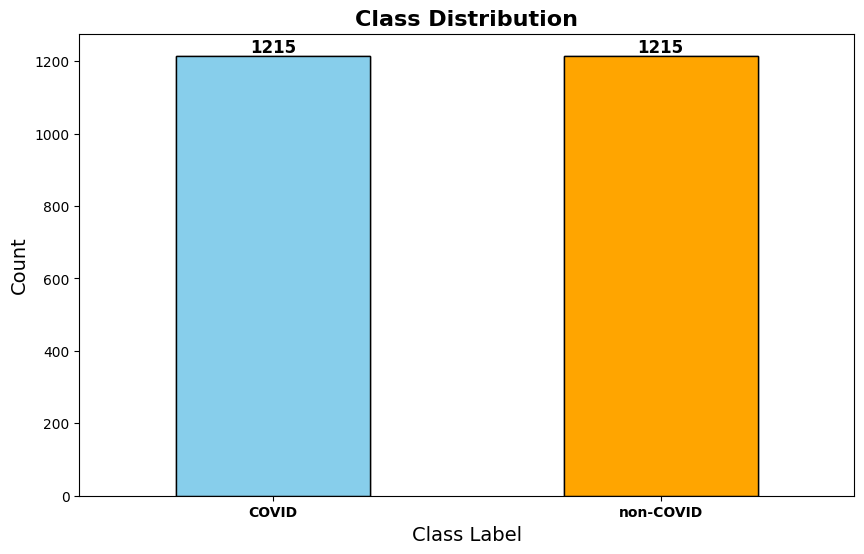

In [162]:
# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.title("Class Distribution", fontsize=16, weight="bold")
plt.xlabel("Class Label", fontsize=14) 
plt.ylabel("Count", fontsize=14)
df["Class Label"].value_counts().plot(kind="bar", edgecolor="black")

# Define colors for each class
colors = ["skyblue", "orange"]

# Plot bar chart with different colors for each bar
df_counts = df["Class Label"].value_counts()
df_counts.plot(kind="bar", edgecolor="black", color=colors)

# Add labels to the bars
for i, count in enumerate(df["Class Label"].value_counts()):
    plt.text(i, count + 10, str(count), ha="center", fontsize=12, weight="bold")

# Set X label to horizontal
plt.xticks(rotation=0)
# Set font weight for x-axis tick labels
plt.xticks(range(len(df_counts.index)), [f"{label}" for label in df_counts.index], weight="bold")

# Save the plot to path
plot_path = os.path.join(PLOT_PATH, "class_distribution_plot.jpg") 
plt.savefig(plot_path, dpi=96)

# Display the plot
plt.show()

This code cell defines several utility functions for handling datasets:

1. `load_dataset(dataset_path)`: Loads data into Keras datasets using TensorFlow's `image_dataset_from_directory` utility. It splits the data into training and test datasets with a validation split of 0.2, shuffles the training data, and sets the image size and batch size based on constants.

2. `data_normalization(tf_dataset)`: Normalizes the data by rescaling pixel values to the range [0, 1]. It also configures the dataset for performance by prefetching data using TensorFlow's AUTOTUNE mechanism.

3. `image_to_array(tf_dataset)`: Converts a TensorFlow dataset object into NumPy arrays. It iterates through the TensorFlow dataset to extract images and labels, appends them to separate lists, and then converts them into NumPy arrays.

These functions collectively enable loading, preprocessing, and conversion of image datasets for machine learning tasks.

In [166]:
def load_dataset(dataset_path):
    """
     Load data into Keras datasets.
     
     Note:
        - The function uses TensorFlow's `image_dataset_from_directory` utility to load the datasets.
        - Training and Test datasets are split with a `validation_split` of 0.2.
        - The datasets are shuffled for training purposes.
        - The image size and batch size are determined by constants.

    :param dataset_path: The directory path containing data.

    :returns: A tuple containing two datasets: Training dataset and Test dataset.
    """
    # Training dataset
    print("\n> Training set:")
    training_set = keras.utils.image_dataset_from_directory(
        dataset_path,
        labels="inferred",
        label_mode="binary",
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=123,
        validation_split=0.2,
        subset="training"
    )
    
    # Test dataset
    print("\n> Test set:")
    test_set = keras.utils.image_dataset_from_directory(
        dataset_path,
        labels="inferred",
        label_mode="binary",
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False,
        seed=123,
        validation_split=0.2,
        subset="validation"   
    )
    
    return training_set, test_set
    

# Data Normalization
def data_normalization(tf_dataset):
    """
    Normalize the data

    Note:
        - Standardizes the data by rescaling pixel values to the range [0, 1].
        - The dataset is configured for performance by prefetching data using TensorFlow's AUTOTUNE mechanism.

    :param tf_dataset: tf.data.Dataset, The dataset to be normalized.

    :return: tf.Dataset.data object.
    """
    # Standardize the data
    normalization_layer = keras.layers.Rescaling(1. / 255)
    dataset = tf_dataset.map(lambda x, y: (normalization_layer(x), y))

    # Configure the dataset for performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


# Convert TensorFlow datasets to NumPy arrays
def dataset_to_array(dataset):
    """
    Convert TensorFlow dataset to NumPy arrays.

    :param dataset: TensorFlow dataset object.

    :return: A tuple containing two NumPy arrays:
        - x_array: Input images.
        - y_array: Corresponding class labels.
    """
    x_array, y_array = [], []

    for image_batch, label_batch in dataset:
        for image, label in zip(image_batch.numpy(), label_batch.numpy()):
            x_array.append(image)
            y_array.append(label)

    # Convert lists to NumPy arrays
    x_array = np.array(x_array)
    y_array = np.array(y_array)

    return x_array, y_array


In [171]:
# Load the keras dataset
training_dataset, test_dataset = load_dataset(DATASET_PATH)

# Printing information about the datasets
print("\n> Class Names:"
      "\n- Class 0 = {}"
      "\n- Class 1 = {}".format(training_dataset.class_names[0], training_dataset.class_names[1]))

# Scaling data
training_ds = data_normalization(tf_dataset=training_dataset)
test_ds = data_normalization(tf_dataset=test_dataset)

# Convert scaled datasets to arrays
X_train, y_train = dataset_to_array(training_ds)
X_test, y_test = dataset_to_array(test_ds)

# Print the shapes of the arrays
print("\n> Shape of Training Data:")
print("- X_train:", X_train.shape)
print("- y_train:", y_train.shape)

print("\n> Shape of Test Data:")
print("- X_test:", X_test.shape)
print("- y_test:", y_test.shape)



> Training set:

> Test set:

> Class Names:
- Class 0 = COVID
- Class 1 = non-COVID


2024-03-25 12:30:48.914318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



> Shape of Training Data:
- X_train: (1944, 224, 224, 3)
- y_train: (1944, 1)

> Shape of Test Data:
- X_test: (486, 224, 224, 3)
- y_test: (486, 1)


2024-03-25 12:30:49.598291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
